In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import collections
from tqdm import tqdm

import seaborn as sns
import torch
from torch import nn

import sklearn
import sklearn.metrics

sns.set_style('whitegrid')


In [ ]:
# ----------------------- Data loading and preprocessig ---------------------- #

file_train = 'ZipDigits.train'
file_test = 'ZipDigits.test'


def read_data(file_name):
    digits = []
    images = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [float(i) for i in line]
            digit = int(line[0])
            data = line[1:]
            images.append(data)
            digits.append(digit)
    return np.array(images), np.array(digits)


def get_features(file_name):
    images, digits = read_data(file_name)
    images = images.reshape(-1, 16, 16)
    images = (images + 1) / 2  # normalize between [0,1]

    # index = (digits == 1) | (digits == 5)
    # images = images[index]
    # digits = digits[index]

    # Extract feature
    intensities = images.reshape(-1, 16 * 16).mean(axis=-1)
    symmetry = np.power(images[..., ::-1] - images, 2).reshape(
        images.shape[0], -1).mean(axis=-1)

    # symmetry = (np.abs(images[..., ::-1] - images).reshape(
    #     images.shape[0], -1).mean(axis=-1) +
    #             1 * np.abs(images[..., ::-1, :] - images).reshape(
    #                 images.shape[0], -1).mean(axis=-1))

    ind_1 = (digits == 1)
    # ind_5 = (digits == 5)
    ind_5 = (digits != 1)
    labels = np.zeros(digits.shape[0])
    labels[ind_1] = 1
    labels[ind_5] = -1
    features = np.concatenate((intensities[:, None], symmetry[:, None]),
                              axis=1)
    return features, labels


# ------------------------------ train features ------------------------------ #
features_train, labels_train = get_features(file_train)

# ------------------------------- test features ------------------------------ #
features_test, labels_test = get_features(file_test)

# ----------------------------- combine the data ----------------------------- #
features = np.concatenate((features_train, features_test), axis=0)
labels = np.concatenate((labels_train, labels_test), axis=0)


In [ ]:
# normalize features
import sklearn.preprocessing as preprocessing

features = preprocessing.MinMaxScaler(
    feature_range=(-1, 1)).fit_transform(features)

# split test and train
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=300, random_state=78)

# standardize features
standardizer = preprocessing.StandardScaler().fit(features_train)
features_train = standardizer.fit_transform(features_train)
features_test = standardizer.transform(features_test)

# plot features and labels
plt.figure(figsize=(3, 3))
plt.scatter(features_train[:, 0],
            features_train[:, 1],
            c=labels_train,
            cmap='coolwarm')
plt.figure(figsize=(3, 3))
plt.scatter(features_test[:, 0],
            features_test[:, 1],
            c=labels_test,
            cmap='coolwarm')


In [ ]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf,
                           features_train,
                           labels_train,
                           title='decision boundary'):
    cmap_light = ListedColormap(["orange", "green"])
    cmap_dark = ListedColormap(["darkorange", "darkgreen"])

    xx, yy = np.meshgrid(np.arange(-2, 2, 0.02), np.arange(-2, 2, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(features_train[:, 0],
                features_train[:, 1],
                c=labels_train,
                s=30,
                cmap=cmap_dark,
                edgecolors="black")
    plt.title(title)

In [114]:
# ------------------------------ manual pytorch ------------------------------ #
class NNLayerTorch():
    def __init__(self, dims=[2, 10, 1], eps=1) -> None:
        torch.random.manual_seed(78)
        self.dims = dims
        self.W0, self.b0, self.W1, self.b1 = self.init_weights(dims, requires_grad=True, eps=eps)
        self.params = [self.W0, self.b0, self.W1, self.b1]

    def init_weights(self, dims, requires_grad=True, eps=1):
        W0 = eps * torch.randn(dims[0], dims[1])
        b0 = eps * torch.randn(dims[1])
        W1 = eps * torch.randn(dims[1], dims[2])
        b1 = eps * torch.randn(dims[2])
        out = W0, b0, W1, b1
        if requires_grad:
            for param in out:
                param.requires_grad = True
        return out

    def set_params(self, state_dict):
        for i, par in enumerate(self.params):
            par.data = state_dict[i].data

    def get_params(self):
        return [par.data for par in self.params]

    def forward(self, x, params=None):
        if params is None:
            params = [self.W0, self.b0, self.W1, self.b1]
        W0, b0, W1, b1 = params
        x = torch.mm(x, W0) + b0
        x = torch.tanh(x)
        x = torch.mm(x, W1) + b1
        x = x.flatten()
        return x

    def forward_loss(self, x, y, params=None, weight_decay=None):
        pred = self.forward(x, params)
        loss = (1. / 4 * (pred - y) ** 2).mean()
        if weight_decay is not None:
            weight_sum = sum(q.pow(2).sum() for q in self.params)
            loss += weight_decay * weight_sum
        return loss, pred

    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self, lr=0.01):
        for param in self.params:
            param.data = param.data - param.grad.data * lr
        return param

    def get_updated_params(self, lr=0.01):
        params_new = self.init_weights(self.dims, requires_grad=False)
        for par, param in zip(params_new, self.params):
            par.requires_grad = False
            if param.grad is not None:
                grad = param.grad.data
            else:
                grad = 0
            par.data = param.data - grad * lr
        return params_new


# ---------------------------------- trainer --------------------------------- #
class Trainer(object):
    def __init__(self, model, lr=1e-3, alpha=1.05, beta=0.8, weight_decay=0.01/300) -> None:
        super().__init__()
        self.model = model
        self.lr = lr
        self.current_lr = lr
        self.alpha = alpha
        self.beta = beta
        self.weight_decay = weight_decay

    def train_batch_var_lr(self, X, Y):
        # self.model.train()
        self.model.zero_grad()

        loss, preds = self.model.forward_loss(X, Y, weight_decay=self.weight_decay)
        loss.backward()

        with torch.no_grad():
            params_new = self.model.get_updated_params(lr=self.current_lr)
            loss_new, _ = self.model.forward_loss(X, Y, params_new)
            if loss_new < loss:
                self.model.step(lr=self.current_lr)
                self.current_lr = self.current_lr * self.alpha
            else:
                self.current_lr = self.current_lr * self.beta
        return loss.item(), preds.detach()

    def train_batch(self, X, Y):
        # self.model.train()
        loss, preds = self.model.forward_loss(X, Y, weight_decay=self.weight_decay)
        self.model.zero_grad()
        loss.backward()
        self.model.step(lr=self.current_lr)
        return loss.item(), preds.detach()


    def calc_metrics(self, y, pred):
        y = y.detach().numpy()
        pred = np.sign(pred.detach().numpy())

        # precision
        prec = None  #sklearn.metrics.precision_score(y, pred)
        # recall
        rec = None  # sklearn.metrics.recall_score(y, pred)

        return np.mean(y == pred), prec, rec

    @torch.no_grad()
    def predict_loss(self, X, Y):
        loss, preds = self.model.forward_loss(X, Y, weight_decay=self.weight_decay)
        return loss.item(), preds.detach()

    @torch.no_grad()
    def predict(self, X):
        X = torch.from_numpy(X).float()
        with torch.no_grad():
            preds = self.model.forward(X)
        preds = np.sign(preds.detach().numpy())
        return preds


class Metrics(object):
    def __init__(self, log_interval=100) -> None:
        self.losses = []
        self.losses_ = []
        self.precisions = []
        self.recalls = []
        self.accuracies = []
        self.log_interval = log_interval

    def update(self, loss, acc, prec, rec):
        self.losses_.append(loss)
        self.losses.append(np.mean(self.losses_[-10:]))
        self.precisions.append(prec)
        self.recalls.append(rec)
        self.accuracies.append(acc)

    def get_latest_metrics(self):
        _loss = np.mean(self.losses_[-self.log_interval:])
        _acc = np.mean(self.accuracies[-self.log_interval:])
        _prec = None  # np.mean(self.precisions[-self.log_interval:])
        _rec = None  # np.mean(self.recalls[-self.log_interval:])
        return _loss, _acc, _prec, _rec


In [ ]:
dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(features_train).float(),
    torch.from_numpy(labels_train).float())
bs = 300


In [ ]:
# ------------- variable learning rate gradient descent heuristic ------------ #
model = NNLayerTorch(dims=[2, 10, 1], eps=1)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

lr = 1
trainer = Trainer(model, lr=lr, alpha=1.05, beta=0.6, weight_decay=None)

log_interval = int(len(dataloader))
metrics = Metrics(log_interval=log_interval)

max_iter = int(1e4)
iteration = 0
obar = tqdm(range(max_iter), desc='Training')

while iteration < max_iter:
    # for ep in range(int(max_iter)):
    for i, (x, y) in enumerate(dataloader):
        loss, preds = trainer.train_batch_var_lr(x, y)
        # loss, preds = trainer.train_batch(x, y)
        score, prec, rec = trainer.calc_metrics(y, preds)
        metrics.update(loss, score, prec, rec)
    if iteration % log_interval == 0:
        r_loss, r_acc, r_prec, r_rec = metrics.get_latest_metrics()
        obar.set_postfix({
            'loss': r_loss,
            'acc': r_acc,
            'lr': trainer.current_lr
        })
        obar.update(log_interval)
    iteration += len(dataloader)
obar.close()

fig, ax = plt.subplots(1, 1)
ax.plot(metrics.losses)
ax.set_yscale('log')
ax.set_xscale('log')

plt.figure(figsize=(4, 4))
plot_decision_boundary(trainer, features_train, labels_train)

In [ ]:
# ------------- variable learning rate gradient descent heuristic ------------ #
model = NNLayerTorch(dims=[2, 10, 1], eps=1)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

lr = 1
trainer = Trainer(model, lr=lr, alpha=1.05, beta=0.6, weight_decay=0.01/300)

log_interval = int(len(dataloader))
metrics = Metrics(log_interval=log_interval)

max_iter = int(1e4)
iteration = 0
obar = tqdm(range(max_iter), desc='Training')

while iteration < max_iter:
    # for ep in range(int(max_iter)):
    for i, (x, y) in enumerate(dataloader):
        loss, preds = trainer.train_batch_var_lr(x, y)
        score, prec, rec = trainer.calc_metrics(y, preds)
        metrics.update(loss, score, prec, rec)
    if iteration % log_interval == 0:
        r_loss, r_acc, r_prec, r_rec = metrics.get_latest_metrics()
        obar.set_postfix({
            'loss': r_loss,
            'acc': r_acc,
            'lr': trainer.current_lr
        })
        obar.update(log_interval)
    iteration += len(dataloader)
obar.close()

fig, ax = plt.subplots(1, 1)
ax.plot(metrics.losses)
ax.set_yscale('log')
ax.set_xscale('log')

plt.figure(figsize=(4, 4))
plot_decision_boundary(trainer, features_train, labels_train)

Training:  15%|█▌        | 1517/10000 [00:10<00:56, 148.97it/s, loss=0.0156, acc=0.99, loss_v=0.0471, acc_v=0.94, lr=1.55]


Early stopping at 1517 for val-loss 0.04440481960773468


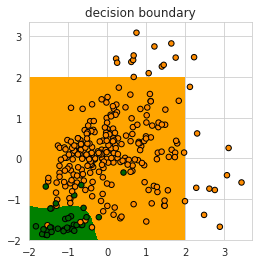

In [131]:
# ------------------------------ early stopping ------------------------------ #
# split train and val
train_features, val_features, train_labels, val_labels = train_test_split(features_train, labels_train, test_size=50, random_state=42)

train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(features_train).float(),
    torch.from_numpy(labels_train).float())
val_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(val_features).float(),
    torch.from_numpy(val_labels).float())
bs = 100
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=True)

model = NNLayerTorch(dims=[2, 10, 1], eps=1)

lr = 1
trainer = Trainer(model, lr=lr, alpha=1.05, beta=0.6, weight_decay=0.01 / 300)

log_interval = int(len(dataloader))
metrics = Metrics(log_interval=log_interval)
metrics_val = Metrics(log_interval=log_interval)

max_iter = int(1e4)
iteration = 0
obar = tqdm(range(max_iter), desc='Training')

best_weight = None
best_val_loss = float('inf')
patience = 300
cur_patience = 0

while iteration < max_iter:
    for i, (x, y) in enumerate(dataloader_train):
        loss, preds = trainer.train_batch_var_lr(x, y)
        score, prec, rec = trainer.calc_metrics(y, preds)
        metrics.update(loss, score, prec, rec)

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader_val):
            _loss, _preds = trainer.predict_loss(x, y)
            _score, _prec, _rec = trainer.calc_metrics(y, _preds)
            metrics_val.update(_loss, _score, _prec, _rec)

    avg_val_loss = metrics_val.get_latest_metrics()[0]
    if  avg_val_loss < best_val_loss:
        best_weight = model.get_params()
        best_val_loss = avg_val_loss
        cur_patience = 0
    else:
        cur_patience += 1

    if cur_patience > patience:
        print(f'Early stopping at {iteration} for val-loss {best_val_loss}')
        model.set_params(best_weight)
        break

    if iteration % log_interval == 0:
        r_loss, r_acc, r_prec, r_rec = metrics.get_latest_metrics()
        vr_loss, vr_acc, *_ = metrics_val.get_latest_metrics()

        obar.set_postfix({
            'loss': r_loss,
            'acc': r_acc,
            'loss_v': vr_loss,
            'acc_v': vr_acc,
            'lr': trainer.current_lr
        })

        obar.update(log_interval)
    iteration += len(dataloader)
obar.close()

plt.figure(figsize=(4, 4))
plot_decision_boundary(trainer, features_train, labels_train)

In [123]:
# test
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(features_test).float(),torch.from_numpy(labels_test).float())
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=bs, shuffle=False)

model.set_params(best_weight)

preds = []
gts = []
for x,y in dataloader_test:
    out = model.forward(x)
    pred = np.sign(out.detach().numpy())
    preds.extend(pred.tolist())
    gts.extend(y.detach().numpy().tolist())

acc = sklearn.metrics.accuracy_score(gts, preds)
prec = sklearn.metrics.precision_score(gts, preds)
rec = sklearn.metrics.recall_score(gts, preds)
fscore = sklearn.metrics.f1_score(gts, preds)
print(f'Test:: accuracy: {acc:.4f}, precision: {prec:.4f}, recall: {rec:.4f}, f1: {fscore:.4f}')

Test:: accuracy: 0.9613, precision: 0.9204, recall: 0.7862, f1: 0.8480
